In [74]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
difficulty = 'easy'
model = helpers.load_model(model_path=f"../model_{difficulty}.pt")
model_activations = helpers.ModelActivations(model)
venv = heist.create_venv(1,0,0,1,difficulty)
layer_paths = helpers.get_model_layer_names(model)
observation = venv.reset()[0]
output, activations = model_activations.run_with_cache(helpers.observation_to_rgb(observation),layer_paths )
print(activations.keys())


dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_max_pool2d', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block0', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_0_res_block1', 'conv_seqs_0', 'conv_seqs_1_conv', 'conv_seqs_1_max_pool2d', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block0', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_1_res_block1', 'conv_seqs_1', 'conv_seqs_2_conv', 'conv_seqs_2_max_pool2d', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block0', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1', 'conv_seqs_2_res_block1', 'conv_seqs_2', 'hidden_fc', 'logits_fc', 'value_fc'])


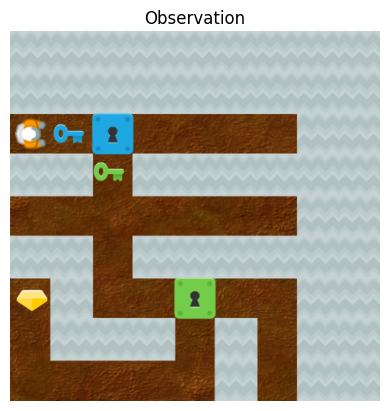

In [76]:
single_frame = venv.render(mode='rgb_array')
helpers.plot_single_observation(single_frame)
layers_to_observe = ["conv_seqs_0_conv", "conv_seqs_0_res_block1", 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block0', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_0_res_block1', 'conv_seqs_0', 'conv_seqs_1_conv', 'conv_seqs_1_max_pool2d', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block0', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_1_res_block1', 'conv_seqs_1']
layers_to_observe = activations.keys()
# helpers.plot_activations_for_layers(activations, layers_to_observe, plot_scale_max = 12)

Want to visualize various other activations. For exaxmple:
* steering vectors
* differences of activations for different inputs (maze with objectives/no objectives)

We can already do this with helpers.plot_activations_for_layers.

So what is left?
1. Extract activations from one forward pass, and another. Take them away as new activations vector and do plot_activations_for_layers for this.



In [172]:
def venv_replace_key(venv, old_color, new_color):
    state = heist.state_from_venv(venv, 0)

    # state.remove_gem()
    x, y = state.get_key_position(old_color)
    print(x,y)
    state.delete_keys_and_locks()

    state.set_key_position(new_color, x, y)

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        _ = venv.reset()
    
    return venv



8.513193130493164 3.4458813667297363


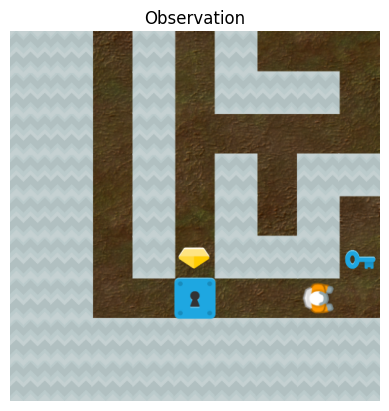

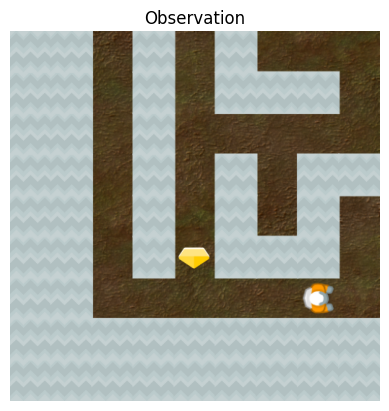

In [177]:
venv = heist.create_venv(1,3,2,1,difficulty)
obs = venv.reset()
unchanged_frame = venv.render(mode = 'rgb_array')

venv = venv_replace_key(venv, 0, 1)
obs_2 = venv.reset()
changed_frame = venv.render(mode = 'rgb_array')
helpers.plot_single_observation(unchanged_frame)

helpers.plot_single_observation(changed_frame)


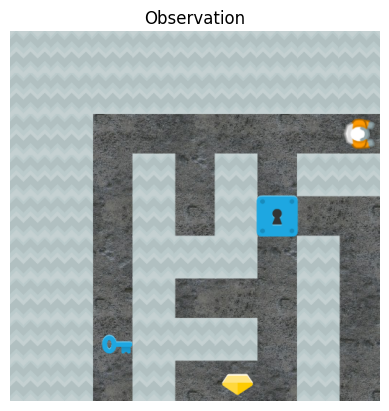

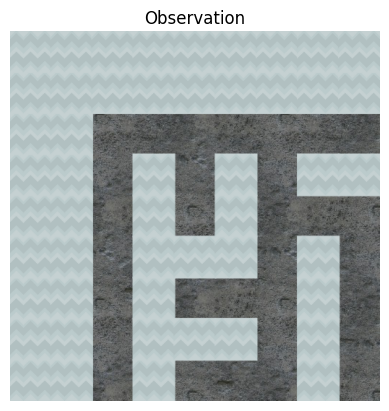

In [46]:
# Remove all entities from maze and plot frames
venv = heist.create_venv(1,0,0,1,difficulty)
state = heist.state_from_venv(venv, 0)

obs_unchanged = venv.reset()
unchanged_frame = venv.render(mode = 'rgb_array')
state.remove_all_entities()
# state.remove_gem()

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs_changed = venv.reset()

changed_frame = venv.render(mode='rgb_array')
helpers.plot_single_observation(unchanged_frame)
helpers.plot_single_observation(changed_frame)



In [48]:
# Remove all entities from maze and plot frames
venv = heist.create_venv(1,0,0,1,difficulty)
state = heist.state_from_venv(venv, 0)

obs_unchanged = venv.reset()
unchanged_frame = venv.render(mode = 'rgb_array')
state.remove_all_entities()
# state.remove_gem()

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs_changed = venv.reset()

changed_frame = venv.render(mode='rgb_array')

output, unchanged_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_unchanged),layer_paths )
output, changed_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_changed),layer_paths )


difference_activations = {}
for key in unchanged_activations.keys():
    difference_activations[key] = (unchanged_activations[key][0] - changed_activations[key][0],)

layers_to_observe = changed_activations.keys()
# helpers.plot_single_observation(unchanged_frame)
# helpers.plot_activations_for_layers(difference_activations, layers_to_observe, plot_scale_max = 12)


In [54]:
# Gem Vs No Gem
venv = heist.create_venv(1,0,0,1,difficulty)
state = heist.state_from_venv(venv, 0)

obs_unchanged = venv.reset()
unchanged_frame = venv.render(mode = 'rgb_array')
# state.remove_all_entities()
state.remove_gem()

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs_changed = venv.reset()

changed_frame = venv.render(mode='rgb_array')

output, unchanged_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_unchanged),layer_paths )
output, changed_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_changed),layer_paths )


difference_activations = {}
for key in unchanged_activations.keys():
    difference_activations[key] = (-unchanged_activations[key][0] + changed_activations[key][0],)

layers_to_observe = changed_activations.keys()
# helpers.plot_single_observation(unchanged_frame)
# helpers.plot_activations_for_layers(difference_activations, layers_to_observe, plot_scale_max = 5)


In [119]:
# Objective N Vs Objective N+1
venv = heist.create_venv(1,6,1,1,difficulty)
state = heist.state_from_venv(venv, 0)

obs_unchanged = venv.reset()
unchanged_frame = venv.render(mode = 'rgb_array')

state.delete_specific_keys(["blue"])
state.delete_specific_locks(["blue"])

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs_change_1 = venv.reset()


change_1_frame = venv.render(mode='rgb_array')


state.delete_specific_keys(["blue", "green"])
state.delete_specific_locks(["blue"])

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs_changed = venv.reset()

changed_frame = venv.render(mode='rgb_array')

output, unchanged_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_unchanged),layer_paths )
output, changed_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_changed),layer_paths )


difference_activations = {}
for key in unchanged_activations.keys():
    difference_activations[key] = (-unchanged_activations[key][0] + changed_activations[key][0],)

layers_to_observe = changed_activations.keys()
# helpers.plot_single_observation(change_1_frame)
# helpers.plot_single_observation(changed_frame)
# helpers.plot_activations_for_layers(difference_activations, layers_to_observe, plot_scale_max = 12)


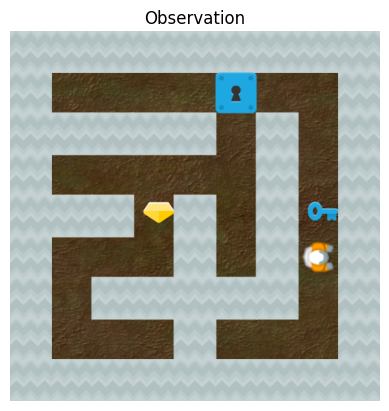

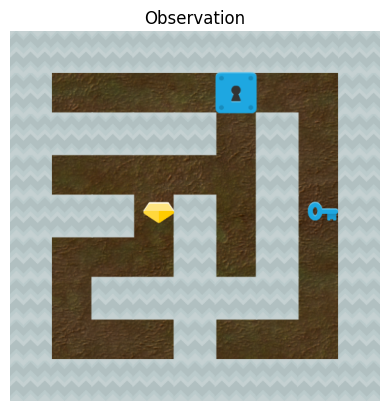

In [128]:
# Player VS no player
venv = heist.create_venv(1,0,0,1,difficulty)
state = heist.state_from_venv(venv, 0)

obs_unchanged = venv.reset()
unchanged_frame = venv.render(mode = 'rgb_array')
# state.remove_all_entities()
# print(state.mouse_pos)
state.remove_mouse()

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs_changed = venv.reset()

changed_frame = venv.render(mode='rgb_array')

output, unchanged_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_unchanged),layer_paths )
output, changed_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs_changed),layer_paths )


difference_activations = {}
for key in unchanged_activations.keys():
    difference_activations[key] = (-unchanged_activations[key][0] + changed_activations[key][0],)

layers_to_observe = changed_activations.keys()
helpers.plot_single_observation(unchanged_frame)
helpers.plot_single_observation(changed_frame)
# helpers.plot_activations_for_layers(difference_activations, layers_to_observe, plot_scale_max = 12)
